In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/moduleend-mentor-session/Dataset.csv


# Problem statement
## Prediction of Patient no-show in a clinic/hospital

## Data:

This analysis consists of exploring a dataset containing approximately 100k medical appointments from the Brazilian public health system known as SUS (Single Health System). 

### Attributes Description:

* PatientId: Identification of a patient
* AppointmentID: Identification of each appointment
* Gender: Male or Female
* ScheduledDay: The day someone called or registered the appointment
* AppointmentDay: The day of the actual appointment, when they have to visit the doctor
* Age: How old is the patient
* Neighbourhood: Where the appointment takes place
* Scholarship: True or False, indicates if the patient is in the Bolsa Familia program (a social welfare program of the Government of Brazil)
* Hypertension: True or False
* Diabetes: True or False
* Alcoholism: True or False
* Handicap: True or False
* SMS_received: 1 or more messages sent to the patient
* No-show: "No" indicates if the patient attended to their appointment and "Yes" if they didn't attend

## Error Metric : Recall

For this problem, minimizing Type II errors is a priority. A Type II error here is a situation where the algorithm incorrectly posits a patient will turn up for an appointment, but they do not present themselves for the scheduled appointment. The inverse situation, in which the prediction is a patient no-attendance, but they do attend the appointment is less of a burden on the practice and has fewer negative impacts for the patient than not receiving care. The prediction as no-attendance, but the patient does attend, is the Type I error. The most successful algorithm is defined as one with high recall.

In [2]:
import numpy as np
import pandas as pd

import datetime
import plotly
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import StratifiedShuffleSplit

from xgboost import XGBClassifier



from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('../input/moduleend-mentor-session/Dataset.csv')
df.shape

(110527, 14)

In [4]:
pd.set_option('display.max_columns',1000)

In [5]:
df.rename(columns={'Hipertension': 'Hypertension', 'Handcap': 'Handicapped' }, inplace=True)

In [6]:
df.describe(include='all')

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicapped,SMS_received,No-show
count,1.105270e+05,1.105270e+05,110527,110527,110527,110527.000000,110527,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527
unique,NaN,NaN,2,103549,27,NaN,81,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,NaN,F,2016-05-06T07:09:54Z,2016-06-06T00:00:00Z,NaN,JARDIM CAMBURI,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,NaN,NaN,71840,24,4692,NaN,7717,NaN,NaN,NaN,NaN,NaN,NaN,88208
mean,1.474963e+14,5.675305e+06,NaN,NaN,NaN,37.088874,NaN,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026,NaN
std,2.560949e+14,7.129575e+04,NaN,NaN,NaN,23.110205,NaN,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873,NaN
min,3.921784e+04,5.030230e+06,NaN,NaN,NaN,-1.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
25%,4.172614e+12,5.640286e+06,NaN,NaN,NaN,18.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
50%,3.173184e+13,5.680573e+06,NaN,NaN,NaN,37.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
75%,9.439172e+13,5.725524e+06,NaN,NaN,NaN,55.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN


In [7]:
col_names=['PatientId','AppointmentID', 'Gender','Neighbourhood','Scholarship', 'Hypertension','Diabetes','Alcoholism','Handicapped', 'SMS_received', 'No-show']
df[col_names] = df[col_names].astype('category')

In [8]:
df['Handicapped']=df['Handicapped'].astype('int')
df.loc[df.Handicapped > 1, 'Handicapped'] = 1
df['Handicapped']=df['Handicapped'].astype('category')
df.Handicapped.value_counts()

0    108286
1      2241
Name: Handicapped, dtype: int64

In [9]:
df=df.drop(['AppointmentID','PatientId'], axis=1)

In [10]:
df.loc[df.Age < 0, ['Age']] = 0

In [11]:
df = df.rename(columns={'No-show': 'No_show'})

In [12]:
df['Scheduled_DateTime'] = pd.to_datetime(df['ScheduledDay'])
df['Scheduled_date'] = df['Scheduled_DateTime'].dt.date
df['Scheduled_month']=df['Scheduled_DateTime'].dt.month
df['Scheduled_hour'] = df['Scheduled_DateTime'].dt.hour
df['Scheduled_weekday']=df['Scheduled_DateTime'].dt.weekday

df['Appointment_DateTime'] = pd.to_datetime(df['AppointmentDay'])
df['Appointment_date'] = df['Appointment_DateTime'].dt.date
df['Appointment_month']=df['Appointment_DateTime'].dt.month
df['Appointment_hour'] = df['Appointment_DateTime'].dt.hour
df['Appointment_weekday']=df['Appointment_DateTime'].dt.weekday

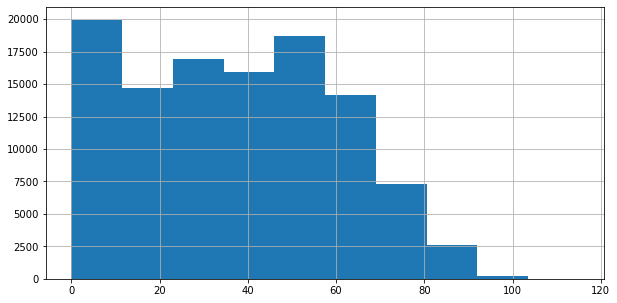

In [13]:
df.Age.hist(figsize=(10,5))

In [14]:
def barplot(column, df):
    barplot1=sns.countplot(x=column, data=df)
    total = len(df[column])
    for p in barplot1.patches:
        height=p.get_height()
        percentage = '{:.2f}%'.format(100 * p.get_height()/total)
        barplot1.text(p.get_x() + p.get_width()/2, height+1, percentage, ha='center')

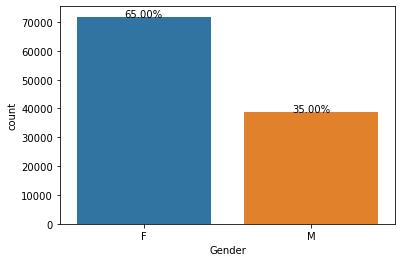

In [15]:
barplot('Gender',df)

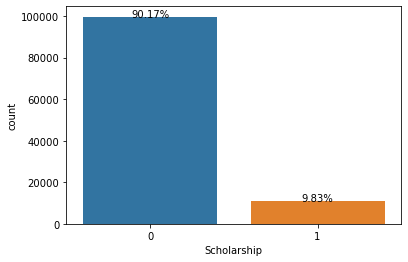

In [16]:
barplot('Scholarship',df)

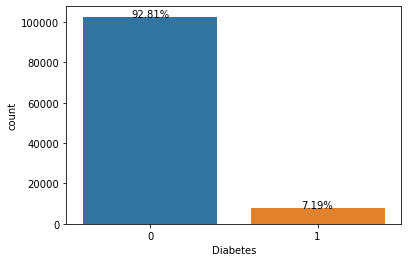

In [17]:
barplot('Diabetes',df)

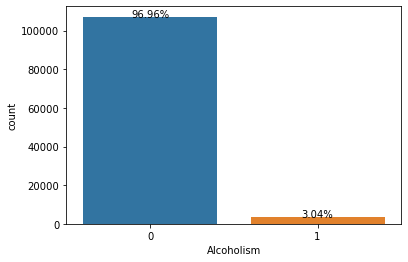

In [18]:
barplot('Alcoholism',df)

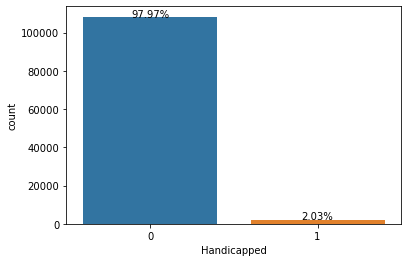

In [19]:
barplot('Handicapped',df)

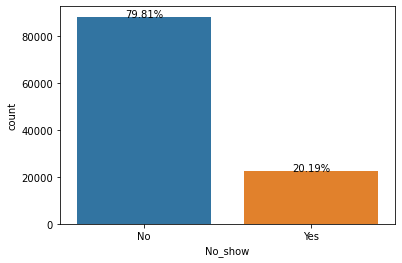

In [20]:
barplot('No_show',df)

In [21]:
def get_probablity(col,target,df,forGraph=True):
    crosstab = pd.crosstab(index=df[col], columns=df[target])
    crosstab.columns = pd.Index(list(crosstab.columns))
    crosstab = crosstab.reset_index()
    crosstab['total'] = crosstab['Yes'] + crosstab['No']
    crosstab['prob'] = crosstab['Yes']/crosstab['total']
    if forGraph:
        return crosstab[[col,'prob']]
    else:
        return crosstab[[col, 'total', 'prob']]

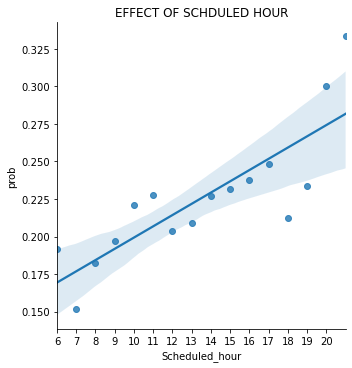

In [24]:
data = get_probablity('Scheduled_hour','No_show',df)
sns.lmplot(data=data,x='Scheduled_hour',y='prob',fit_reg=True)
plt.xticks(np.arange(np.min(df['Scheduled_hour']), np.max(df['Scheduled_hour'])))
plt.title('EFFECT OF SCHDULED HOUR')
plt.show()

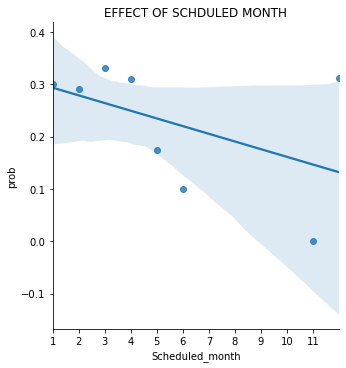

In [25]:
data = get_probablity('Scheduled_month','No_show',df)
sns.lmplot(x='Scheduled_month',y='prob', data=data, fit_reg=True)
plt.xticks(np.arange(np.min(df['Scheduled_month']), np.max(df['Scheduled_month'])))
plt.title('EFFECT OF SCHDULED MONTH')
plt.show()

In [ ]:
df.No_show.value_counts()

In [26]:
df['No_show']= df['No_show'].replace(to_replace=['No','Yes'], value=[0,1])
df['No_show'].value_counts()

0    88208
1    22319
Name: No_show, dtype: int64

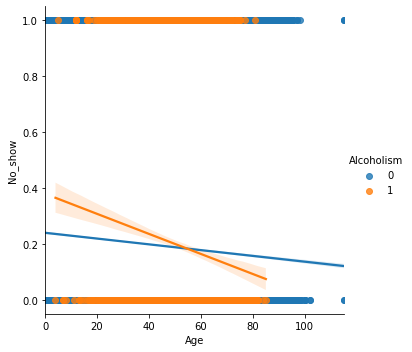

In [27]:
sns.lmplot('Age','No_show',hue='Alcoholism',data=df)

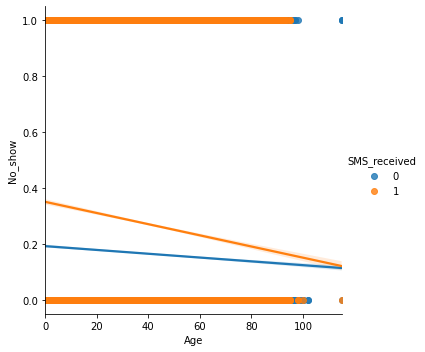

In [28]:
sns.lmplot('Age','No_show',hue='SMS_received',data=df)

In [29]:
temp = df.groupby(['Scholarship','No_show']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['Scholarship','No_show','Count']

trace1 = go.Bar(x=temp.Scholarship[temp.No_show==0], y=temp.Count[temp.No_show==0]/temp.Count.sum(), 
               name="NO_SHOW")
trace2 = go.Bar(x=temp.Scholarship[temp.No_show==1], y=temp.Count[temp.No_show==1]/temp.Count.sum(),
               name="Attended")
data = [trace1, trace2]
layout = go.Layout(width=800, height=600, title="No Show & Scholarship")
fig = go.Figure(data=data, layout=layout)
fig.show()

In [30]:
temp = df.groupby(['Hypertension','No_show']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['Hypertension','No_show','Count']

trace1 = go.Bar(x=temp.Hypertension[temp.No_show==0], y=temp.Count[temp.No_show==0]/temp.Count.sum(), 
               name="NO_SHOW")
trace2 = go.Bar(x=temp.Hypertension[temp.No_show==1], y=temp.Count[temp.No_show==1]/temp.Count.sum(),
               name="Attended")
data = [trace1, trace2]
layout = go.Layout(width=800, height=600, title="No Show & Hypertension")
fig = go.Figure(data=data, layout=layout)
fig.show()

In [31]:
temp = df.groupby(['Diabetes','No_show']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['Diabetes','No_show','Count']

trace1 = go.Bar(x=temp.Diabetes[temp.No_show==0], y=temp.Count[temp.No_show==0]/temp.Count.sum(), 
               name="NO_SHOW")
trace2 = go.Bar(x=temp.Diabetes[temp.No_show==1], y=temp.Count[temp.No_show==1]/temp.Count.sum(),
               name="Attended")
data = [trace1, trace2]
layout = go.Layout(width=800, height=600, title="No Show & Diabetes")
fig = go.Figure(data=data, layout=layout)
fig.show()

In [56]:
temp = df.groupby(['Alcoholism','No_show']).size().to_frame()
temp = temp.reset_index()
temp.columns = ['Alcoholism','No_show','Count']

trace1 = go.Bar(x=temp.Alcoholism[temp.No_show==0], y=temp.Count[temp.No_show==0]/temp.Count.sum(), 
               name="NO_SHOW")
trace2 = go.Bar(x=temp.Alcoholism[temp.No_show==1], y=temp.Count[temp.No_show==1]/temp.Count.sum(),
               name="Attended")
data = [trace1, trace2]
layout = go.Layout(width=800, height=600, title="No Show & Alcoholism")
fig = go.Figure(data=data, layout=layout)
fig.show()

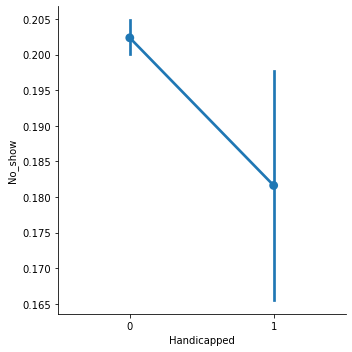

In [57]:
sns.factorplot('Handicapped','No_show',data=df)

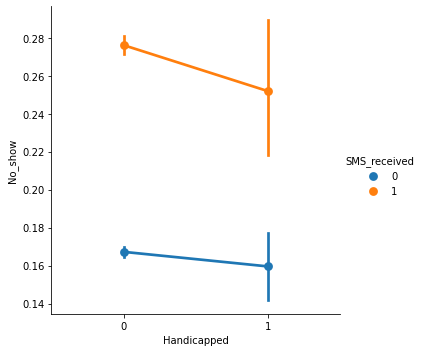

In [59]:
sns.factorplot('Handicapped','No_show',hue='SMS_received',data=df)

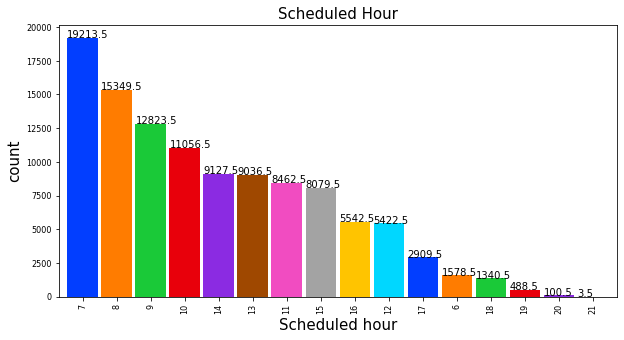

In [37]:
plt.subplots(figsize=(10,5))
ax = df['Scheduled_hour'].value_counts().plot.bar(width=0.9, color=sns.color_palette('bright',20), fontsize=8)
for p in ax.patches:
    ax.annotate(format(p.get_height()+0.5), (p.get_x(),p.get_height()+1))
plt.title('Scheduled Hour', fontsize=15)
plt.xlabel('Scheduled hour', fontsize=15)
plt.ylabel('count',fontsize=15)
plt.show()

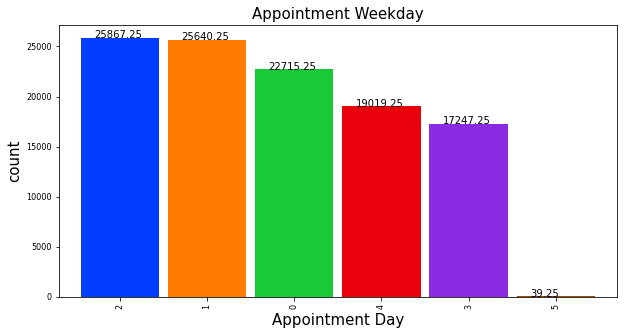

In [46]:
plt.subplots(figsize=(10,5))
ax = df['Appointment_weekday'].value_counts().plot.bar(width=0.9, color=sns.color_palette('bright',20), fontsize=8)
for p in ax.patches:
    ax.annotate(format(p.get_height()+0.25), (p.get_x()+0.155,p.get_height()+1))
plt.title('Appointment Weekday', fontsize=15)
plt.xlabel('Appointment Day', fontsize=15)
plt.ylabel('count',fontsize=15)
plt.show()

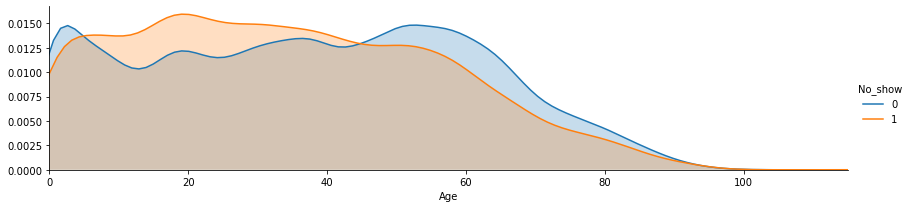

In [49]:
fig = sns.FacetGrid(df,hue='No_show',aspect=4)
fig.map(sns.kdeplot,'Age',shade=True)
oldest = df['Age'].max()
fig.set(xlim=(0,oldest))
fig.add_legend()

In [34]:
fn = lambda row: (row.Appointment_date - row.Scheduled_date).days
df['num_of_days'] = df.apply (fn, axis=1)

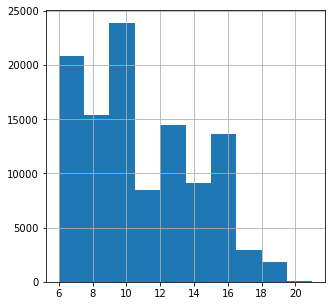

In [60]:
df.Scheduled_hour.hist(figsize=(5,5))

In [ ]:
fn = lambda row: (row.Appointment_date - row.Scheduled_date).days
df['num_of_days'] = df.apply (fn, axis=1)

In [61]:
df.head(2)

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hypertension,Diabetes,Alcoholism,Handicapped,SMS_received,No_show,Scheduled_DateTime,Scheduled_date,Scheduled_month,Scheduled_hour,Scheduled_weekday,Appointment_DateTime,Appointment_date,Appointment_month,Appointment_hour,Appointment_weekday,num_of_days
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,0,2016-04-29 18:38:08+00:00,2016-04-29,4,18,4,2016-04-29 00:00:00+00:00,2016-04-29,4,0,4,0
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,0,2016-04-29 16:08:27+00:00,2016-04-29,4,16,4,2016-04-29 00:00:00+00:00,2016-04-29,4,0,4,0


In [67]:
cat = ['Appointment_weekday','No_show','Appointment_month','Scheduled_weekday',
      'Scheduled_month']
df[cat]=df[cat].astype('category')

In [95]:
df.dtypes

Gender                 category
Age                       int64
Scholarship            category
Hypertension           category
Diabetes               category
Alcoholism             category
Handicapped            category
SMS_received           category
No_show                category
Scheduled_month        category
Scheduled_weekday      category
Appointment_month      category
Appointment_weekday    category
num_of_days               int64
dtype: object

In [97]:
df.drop(['Appointment_month','Scheduled_weekday','Appointment_weekday','Scheduled_month'],axis=1,inplace=True)

In [70]:
df = df.drop(['ScheduledDay','AppointmentDay','Neighbourhood','Scheduled_DateTime',
              'Scheduled_date','Scheduled_DateTime',
              'Appointment_DateTime','Appointment_date'], axis=1)

In [73]:
df.drop('Appointment_hour',axis=1,inplace=True)

In [81]:
df=df.drop('Scheduled_hour',axis=1)

In [75]:
df.loc[df.num_of_days < 0, ['num_of_days']] = 0

In [99]:
y = df['No_show']
X = df.drop('No_show',axis=1)
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.30,stratify=y,random_state=0) 

In [100]:
cat_attr = X_train.select_dtypes('category').columns
num_attr = X_train.select_dtypes(['int64','float64']).columns
cat_attr

Index(['Gender', 'Scholarship', 'Hypertension', 'Diabetes', 'Alcoholism',
       'Handicapped', 'SMS_received'],
      dtype='object')

In [101]:
standard = StandardScaler()
standard.fit(X_train[num_attr])

X_train_std = standard.transform(X_train[num_attr])
X_val_std = standard.transform(X_val[num_attr])

X_train_num = pd.DataFrame(X_train_std,columns=num_attr)
X_val_num = pd.DataFrame(X_val_std, columns=num_attr)

In [107]:
ohe = OneHotEncoder()
ohe.fit(X_train[cat_attr])
columns_ohe = list(ohe.get_feature_names(cat_attr))
print(columns_ohe)
X_train_cat = ohe.transform(X_train[cat_attr])
X_val_cat = ohe.transform(X_val[cat_attr])

X_train_cat = pd.DataFrame(X_train_cat.todense(), columns=columns_ohe)
X_val_cat = pd.DataFrame(X_val_cat.todense(), columns=columns_ohe) 

['Gender_F', 'Gender_M', 'Scholarship_0', 'Scholarship_1', 'Hypertension_0', 'Hypertension_1', 'Diabetes_0', 'Diabetes_1', 'Alcoholism_0', 'Alcoholism_1', 'Handicapped_0', 'Handicapped_1', 'SMS_received_0', 'SMS_received_1']


In [108]:
X_train = pd.concat([X_train_num,X_train_cat],axis=1)
X_val = pd.concat([X_val_num,X_val_cat],axis=1)
X_train.shape

(77368, 16)

In [109]:
X_val.shape

(33159, 16)

In [110]:
scores = pd.DataFrame(columns=['Model','Train_accuracy','Train_recall','Train_precision','Train_f1score'
                              ,'Test_accuracy','Test_recall','Test_precision','Test_f1score'])
def get_metrics(train_actual, train_predicted, test_actual, test_predicted, model_description, dataframe):
    train_accuracy = accuracy_score(train_actual,train_predicted)
    train_recall = recall_score(train_actual,train_predicted,average='weighted')
    train_precision = precision_score(train_actual,train_predicted,average='weighted')
    train_f1score = f1_score(train_actual,train_predicted,average='weighted')
    test_accuracy = accuracy_score(test_actual,test_predicted)
    test_recall = recall_score(test_actual,test_predicted,average='weighted')
    test_precision = precision_score(test_actual,test_predicted,average='weighted')
    test_f1score = f1_score(test_actual,test_predicted,average='weighted')
    dataframe = dataframe.append(pd.Series([model_description,train_accuracy,train_recall,train_precision,train_f1score,
                                          test_accuracy,test_recall,test_precision,test_f1score],
                                           index=scores.columns),ignore_index=True)
    return(dataframe)

# KNN

In [111]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train,y_train)

knn_pred_train = knn.predict(X_train)
knn_pred_val = knn.predict(X_val)
scores = get_metrics(y_train,knn_pred_train,y_val,knn_pred_val,'KNN',scores)
scores

NameError: name 'KNeighborsClassifier' is not defined

# SVM

In [ ]:
support = SVC(C=0.5,kernel='linear')
support.fit(X_train,y_train)
svm_pred_train = support.predict(X_train)
svm_pred_val = support.predict(X_val)

scores = get_metrics(y_train,svm_pred_train,y_val,svm_pred_val,'SVM',scores)
scores

svm_s = SVC()
param_grid = {
     'kernel': ['linear', 'poly', 'rbf'],
    'C' : [0.5, 1.0, 10],
    'gamma' : [0.1, 1, 10]
}

grid = GridSearchCV(svm_s, param_grid, cv=5)
grid.fit(X_train,y_train)

grid_train_svm = grid.predict(X_train)
grid_val_svm = grid.predict(X_val)

grid.best
scores = get_metrics(y_train,grid_train_svm,y_val,grid_val_svm,'SVM_Gridsearch',scores)
scores

# Decision Trees

In [ ]:
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train,y_train)

tree_pred_train = clf.predict(X_train)
tree_pred_val = clf.predict(X_val)

scores = get_metrics(y_train,tree_pred_train,y_val,tree_pred_val,'Decision Trees',scores)
scores

In [ ]:
tree = DecisionTreeClassifier() 

param_grid = { 
    'criterion': ['gini','entropy'], 
    'max_depth' : [None,2,5,7], 
    'min_samples_split' : [2,3,4,7],
    'min_samples_leaf' : [1,2,3]
}

grid = GridSearchCV(tree, param_grid, cv=5) 

grid.fit(X_train,y_train)

In [ ]:
grid_train_tree = grid.predict(X_train) 
grid_val_tree = grid.predict(X_val)
acc_t = accuracy_score(grid_train_tree,y_train)
acc_test = accuracy_score(grid_val_tree,y_val)

print(acc_t)
print(acc_test)

In [ ]:
grid.best_params_

In [ ]:
scores = get_metrics(y_train,grid_train_tree,y_val,grid_val_tree,'Tree_Gridsearch',scores) 
scores

In [ ]:
importances = clf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7,7))
plt.title("Tree Importances")
plt.barh(range(len(indices)),importances[indices])
plt.yticks(range(len(indices)),[features[i] for i in indices], fontsize=10)
plt.show()

In [ ]:
X_train.head(2)

In [ ]:
dec_train.head(2)

In [ ]:
dec_val.head(2)

In [ ]:
dec_train = X_train[['SMS_received_1','Age','Scholarship_0','Hipertension_0','Handcap_2','Gender_F','Alcoholism_1',
                    'Scholarship_1','Alcoholism_0']]
dec_val = X_val[['SMS_received_1','Age','Scholarship_0','Hipertension_0','Handcap_2','Gender_F','Alcoholism_1',
                    'Scholarship_1','Alcoholism_0']]

In [ ]:
clf_imp = DecisionTreeClassifier(max_depth=5)
clf_imp.fit(dec_train,y_train)

imp_tree_pred_train = clf_imp.predict(dec_train)
imp_tree_pred_val = clf_imp.predict(dec_val)

acc_imp_tree_train = accuracy_score(y_train,imp_tree_pred_train)
acc_imp_tree_val = accuracy_score(y_val,imp_tree_pred_val)
print(acc_imp_tree_train)
print(acc_imp_tree_val)

In [ ]:
scores = get_metrics(y_train,imp_tree_pred_train,y_val,imp_tree_pred_val,'Tree_Importances',scores) 
scores

# Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=500)
rf.fit(X_train,y_train)

rf_pred_train = rf.predict(X_train)
rf_pred_val = rf.predict(X_val)

scores = get_metrics(y_train,rf_pred_train,y_val,rf_pred_val,'Random Forest',scores)
scores

In [ ]:
imp_rf = rf.feature_importances_
indices_rf = np.argsort(imp_rf)
features = X_train.columns

%matplotlib inline
plt.figure(figsize=(7,7))
plt.title("RandomForest Importances")
plt.barh(range(len(indices_rf)),imp_rf[indices_rf])
plt.yticks(range(len(indices_rf)), [features[i] for i in indices_rf], fontsize=10)
plt.show()

In [ ]:
forest_train = X_train[['Age','SMS_received_1','SMS_received_0']]
forest_val = X_val[['Age','SMS_received_1','SMS_received_0']]

In [ ]:
rf_imp = RandomForestClassifier(n_estimators=500)
rf_imp.fit(forest_train,y_train)

imp_forest_pred_train = rf_imp.predict(forest_train)
imp_forest_pred_val = rf_imp.predict(forest_val)

acc_imp_forest_train = accuracy_score(y_train,imp_forest_pred_train)
acc_imp_forest_val = accuracy_score(y_val,imp_forest_pred_val)
print(acc_imp_forest_train)
print(acc_imp_forest_val)

In [ ]:
scores = get_metrics(y_train,imp_forest_pred_train,y_val,imp_forest_pred_val,'Forest_Importances',scores) 
scores

# Adaboost

In [ ]:
ada = AdaBoostClassifier(n_estimators = 600,learning_rate = 0.4)
ada.fit(X_train,y_train)

ada_pred_train = ada.predict(X_train)
ada_pred_val = ada.predict(X_val)

ada_train = accuracy_score(y_train, ada_pred_train)
ada_test = accuracy_score(y_val,ada_pred_val)
print(ada_train)
print(ada_test)

In [ ]:
scores = get_metrics(y_train,ada_pred_train,y_val,ada_pred_val,'Ada Boosting',scores)
scores

In [ ]:
features = X_train.columns
imp_ada = ada.feature_importances_
indices_ada = np.argsort(imp_ada)

%matplotlib inline
plt.figure(figsize=(7,7))
plt.title("ADA Importances")
plt.barh(range(len(indices_ada)) ,imp_ada[indices_ada])
plt.yticks(range(len(indices_ada)), [features[i] for i in indices_ada], fontsize=7)
plt.show()

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xg = XGBClassifier(n_estimators=500)
xg.fit(X_train,y_train)
xg_pred_train = xg.predict(X_train)
xg_pred_val = xg.predict(X_val)

scores = get_metrics(y_train,xg_pred_train,y_val,xg_pred_val,'XG Boosting',scores)
scores

In [ ]:
features = X_train.columns
imp_xg = xg.feature_importances_
indices_xg = np.argsort(imp_xg)

%matplotlib inline
plt.figure(figsize=(7,7))
plt.title("XG_Importances")
plt.barh(range(len(imp_xg)), imp_xg[indices_xg])
plt.yticks(range(len(imp_xg)), [features[i] for i in indices_xg])
plt.show()

In [ ]:
xg_train = X_train[['SMS_received_0','Scholarship_0','Alcoholism_0','Age','Gender_F','Hipertension_0','Handcap_1'
                    ,'Diabetes_0','Handcap_0','Handcap_2','Handcap_3']]
xg_val = X_val[['SMS_received_0','Scholarship_0','Alcoholism_0','Age','Gender_F','Hipertension_0','Handcap_1'
                    ,'Diabetes_0','Handcap_0','Handcap_2','Handcap_3']]

In [ ]:
xg_imp = XGBClassifier(n_estimators=500)
xg_imp.fit(xg_train,y_train)

imp_xg_pred_train = xg_imp.predict(xg_train)
imp_xg_pred_val = xg_imp.predict(xg_val)

acc_imp_xg_train = accuracy_score(y_train,imp_xg_pred_train)
acc_imp_xg_val = accuracy_score(y_val,imp_xg_pred_val)
print(acc_imp_xg_train)
print(acc_imp_xg_val)

In [ ]:
scores = get_metrics(y_train,imp_xg_pred_train,y_val,imp_xg_pred_val,'XG_Importances',scores) 
scores

In [ ]:
xg_boost = XGBClassifier()

param = { 
    'n_estimators': [200,400,600], 
    'gamma' : [0.3, 0.5, 0.7, 0.9], 
    'learning_rate' : [0.1,0.3, 0.9]
}

grid_xg = GridSearchCV(xg_boost, param, cv=5) 

grid_xg.fit(X_train,y_train)



grid_train_xg = grid_xg.predict(X_train) 
grid_val_xg = grid_xg.predict(X_val)

acc_xg = accuracy_score(grid_train_xg,y_train)
accu_xg = accuracy_score(grid_val_xg,y_val)

print(acc_xg)
print(accu_xg)

In [ ]:
scores = get_metrics(y_train,grid_train_xg,y_val,grid_val_xg,'Grid_XG Boosting',scores)
scores

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from vecstack import stacking
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
le = preprocessing.LabelEncoder()
le.fit(y_train)

In [ ]:
models = [clf,rf,ada]

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

y_train1 = le.transform(y_train)
y_val1 = le.transform(y_val)

In [ ]:
S_train, S_test = stacking(models,                   
                           X_train, y_train1, X_val,   
                           regression=False,  
       
                           needs_proba=False,
         
                           save_dir=None, 
            
                           metric=accuracy_score, 
    
                           n_folds=4, 
                 
                           stratified=True,
            
                           shuffle=True,  
            
                           random_state=0,    
         
                           verbose=2)

In [ ]:
S_train, S_test = stacking(models,                   
                           X_train,y_train,X_val,regression=False,needs_proba=False,
         
                           save_dir=None,n_folds=4,stratified=True,shuffle=True,random_state=0,verbose=2)                        

In [ ]:
model = GradientBoostingClassifier(random_state=0, 
                           n_estimators=100, max_depth=3)
    
model = model.fit(S_train, y_train1)
y_pred_train=model.predict(S_train)
y_pred_test = model.predict(S_test)

print(accuracy_score(y_train1,y_pred_train))
print(accuracy_score(y_val1,y_pred_test))